In [1]:
import torch
from fm3.fm3 import FM3
from fm3.tokenizer import FastChemTokenizerSelfies
from fm3.flow import get_path, get_source_distribution
from tqdm.notebook import trange

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reload tokenizer
tokenizer = FastChemTokenizerSelfies.from_pretrained("./tokenizer_vocab/selftok_reordered")
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Rebuild model
model = FM3(vocab_size=len(tokenizer), hidden=320, backbone_type="simple").to(device)
model.load_state_dict(torch.load("fm3_discrete.pt", map_location=device))
model.eval()

# Prepare path + source
path = get_path("polynomial", exponent=2.0)
source = get_source_distribution("mask", vocab_size=len(tokenizer))


✅ Special tokens bound: 0 1 2 3 4


🧪 Generating molecules via FM3 (discrete mode)...
✅ Sample 1: COC=CC=CNCCC(O)CCNC=O
✅ Sample 2: CCOC(=O)C(S)CC(=O)NCC1C=CC(=O)N1
✅ Sample 3: C=CCCCC(=O)NNC(=O)NCOCC=CC=CC(C)O
✅ Sample 4: CCOC1=CC(NC(=O)Cc2ccccc2OC)OC(=O)CCNC(=O)NO1
✅ Sample 5: CCCCCCCCOCCCC(O)C=CC=CNOC(O)CCCCC=O
✅ Sample 6: CC(C)NC(C)OC(=O)C=CN=CN=O


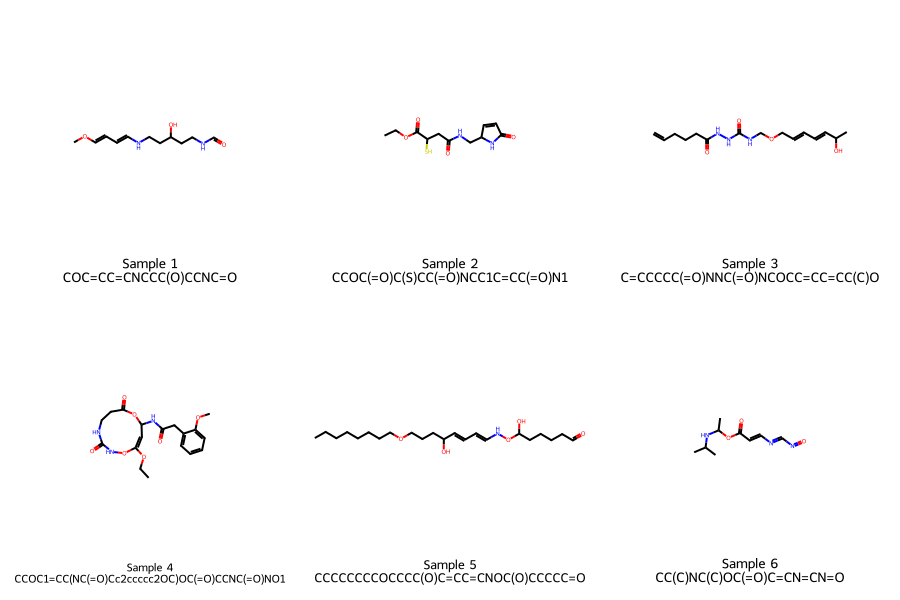


✓ Generated 6/6 valid molecules


In [28]:
# ------------------- FM3 SAMPLING SCRIPT -------------------
import torch
from torchdiffeq import odeint
from rdkit import Chem
from rdkit.Chem import Draw
import selfies as sf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np
from tqdm.notebook import trange, tqdm

# ------------------- CONFIG -------------------
NUM_SAMPLES = 6
MAX_LEN = 12
STEPS = 200
MODE = "discrete"  # choose: "continuous" or "discrete"
TEMPERATURE = 0.35

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device).eval()
tokenizer = tokenizer  # assume already loaded
embedding_weight = model.get_input_embeddings().weight.detach().to(device)

# ------------------- HELPERS -------------------
def tokens_to_selfies(tok_list):
    """Convert token ids to clean SELFIES string"""
    clean = []
    for t in tok_list:
        if t == tokenizer.eos_token_id:
            break
        if t in (tokenizer.pad_token_id, tokenizer.bos_token_id):
            continue
        clean.append(int(t))
    if not clean:
        return ""
    try:
        return tokenizer.decode(clean, skip_special_tokens=True)
    except Exception:
        return " ".join(map(str, clean))

def decode_embeddings_to_tokens(x_final):
    """Nearest-neighbor decoding: embeddings → token IDs"""
    x_flat = x_final.view(-1, model.hidden)
    distances = torch.cdist(x_flat, embedding_weight)
    pred_tokens = torch.argmin(distances, dim=-1)
    return pred_tokens.view(x_final.shape[0], x_final.shape[1])

# ------------------- GENERATION -------------------
print(f"🧪 Generating molecules via FM3 ({MODE} mode)...")

if MODE == "continuous":
    # --- use built-in continuous generation ---
    tokens = model.generate(
        tokenizer=tokenizer,
        num_samples=NUM_SAMPLES,
        seq_len=MAX_LEN,
        steps=STEPS,
        mode="continuous",
    )

elif MODE == "discrete":
    # --- use built-in discrete flow sampling ---
    # we must define "path" and "source" placeholders (optional for your tokenizer)
    path = tokenizer  # not used internally, but passed for consistency
    source = tokenizer
    tokens = model.generate(
        tokenizer=tokenizer,
        path=path,
        source=source,
        num_samples=NUM_SAMPLES,
        seq_len=MAX_LEN,
        steps=STEPS,
        mode="discrete",
        temperature=TEMPERATURE,
    )
else:
    raise ValueError("MODE must be either 'continuous' or 'discrete'.")

# ------------------- POSTPROCESS -------------------
generated_SELFIES, generated_mols = [], []

for i in range(tokens.shape[0]):
    tok_list = tokens[i].cpu().numpy().tolist()
    pred_selfies = tokens_to_selfies(tok_list)
    pred_selfies_clean = pred_selfies.replace(" ", "").strip()

    if not pred_selfies_clean:
        print(f"Sample {i+1}: ❌ Empty SELFIES.")
        continue

    try:
        smi = sf.decoder(pred_selfies_clean)
        mol = Chem.MolFromSmiles(smi)
        if mol is None:
            print(f"Sample {i+1}: invalid SMILES '{smi}'")
            continue

        smi_canon = Chem.MolToSmiles(mol)
        generated_SELFIES.append(smi_canon)
        generated_mols.append(mol)
        print(f"✅ Sample {i+1}: {smi_canon}")

    except Exception as e:
        print(f"Sample {i+1}: Decoding error → {e}")

# ------------------- VISUALIZE -------------------
if generated_mols:
    legends = [f"Sample {i+1}\n{smi}" for i, smi in enumerate(generated_SELFIES)]
    img = Draw.MolsToGridImage(
        generated_mols,
        molsPerRow=min(3, len(generated_mols)),
        subImgSize=(300, 300),
        legends=legends,
        useSVG=False
    )
    display(img)
    print(f"\n✓ Generated {len(generated_SELFIES)}/{NUM_SAMPLES} valid molecules")
else:
    print("⚠ No valid molecules generated.")

# ------------------- OPTIONAL: ANALYZE TRAJECTORY -------------------
if MODE == "continuous":
    print("\nAnalyzing continuous trajectory stats...")
    try:
        with torch.no_grad():
            x0 = torch.randn(1, MAX_LEN, model.hidden, device=device) * 0.1
            t_dense = torch.linspace(0.0, 1.0, 50, device=device)
            traj = [x0]

            for t in t_dense[1:]:
                v = model(traj[-1], t.repeat(1))
                traj.append(traj[-1] + v * (t_dense[1] - t_dense[0]))

            # Detach before stacking
            traj = torch.stack([x.detach() for x in traj])

            norms = traj.norm(dim=-1).mean(dim=(1,2)).detach().cpu()
            stds = traj.std(dim=-1).mean(dim=(1,2)).detach().cpu()

            plt.figure(figsize=(10,4))
            plt.subplot(1,2,1)
            plt.plot(t_dense.cpu().numpy(), norms.numpy())
            plt.xlabel('t'); plt.ylabel('Avg embedding norm'); plt.title('Norm vs t'); plt.grid(True)

            plt.subplot(1,2,2)
            plt.plot(t_dense.cpu().numpy(), stds.numpy())
            plt.xlabel('t'); plt.ylabel('Avg embedding std'); plt.title('Std vs t'); plt.grid(True)

            plt.tight_layout()
            plt.show()

            print(f"Initial norm: {norms[0]:.4f}, Final norm: {norms[-1]:.4f} (Δ {float(norms[-1]-norms[0]):.4f})")

    except Exception as e:
        print(f"Trajectory analysis failed: {e}")
